In [1]:
import os
import time
import datetime
import pandas as pd
import numpy as np
import joblib
import json
import itertools
from pycm import ConfusionMatrix

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import Normalizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

> 基于这篇博客 [[网络安全自学篇] 二十四.基于机器学习的入侵检测和攻击识别——以KDD CUP99数据集为例](https://blog.csdn.net/Eastmount/article/details/103189405)，之后的分析都是自己的改进

## 1. 读取数据

### 1.1 读成表格形式

In [94]:
file = './data2/kddcup.data.txt'
datas = pd.read_csv(file, sep=',', header=None, error_bad_lines=False)

b'Skipping line 4817100: expected 42 fields, saw 56\n'


In [95]:
temp_columns = 'duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_hot_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate '
columns = [i.strip() for i in temp_columns.split(',')] + ['labels']
# columns = ['duration', ' protocol_type', ' service', ' flag', ' src_bytes', ' dst_bytes', ' land', ' wrong_fragment', ' urgent', ' hot', ' num_failed_logins', ' logged_in', ' num_compromised', ' root_shell', ' su_attempted', ' num_root', ' num_file_creations', ' num_shells', ' num_access_files', ' num_outbound_cmds', ' is_hot_login', ' is_guest_login', ' count', ' srv_count', ' serror_rate', ' srv_serror_rate', ' rerror_rate', ' srv_rerror_rate', ' same_srv_rate', ' diff_srv_rate', ' srv_diff_host_rate', ' dst_host_count', ' dst_host_srv_count', ' dst_host_same_srv_rate', ' dst_host_diff_srv_rate', ' dst_host_same_src_port_rate', ' dst_host_srv_diff_host_rate', ' dst_host_serror_rate', ' dst_host_srv_serror_rate', ' dst_host_rerror_rate', ' dst_host_srv_rerror_rate', 'labels']
datas.columns = columns
datas

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898425,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898426,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


In [96]:
# datas.to_csv('./data2/datas.csv', index=False)

### 1.2 查看其一些基本值（最大，最小，均值等）

In [4]:
datas.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,...,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06,4.898430e+06
mean,4.834244e+01,1.834621e+03,1.093623e+03,5.716117e-06,6.487793e-04,7.961735e-06,1.243766e-02,3.205109e-05,1.435288e-01,8.088306e-03,...,2.329811e+02,1.892143e+02,7.537134e-01,3.071111e-02,6.050521e-01,6.464108e-03,1.780912e-01,1.778859e-01,5.792782e-02,5.765943e-02
std,7.233299e+02,9.414312e+05,6.450124e+05,2.390834e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506114e-01,3.856481e+00,...,6.402086e+01,1.059127e+02,4.111859e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821775e-01,2.309428e-01,2.309777e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,4.900000e+01,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.832900e+04,1.379964e+09,1.309937e+09,1.000000e+00,3.000000e+00,1.400000e+01,7.700000e+01,5.000000e+00,1.000000e+00,7.479000e+03,...,2.550000e+02,2.550000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### 1.3 查看数据基本类型

In [5]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898430 entries, 0 to 4898429
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                object 
 2   service                      object 
 3   flag                         object 
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  

In [6]:
grouped_labels = datas.groupby(by=['labels'])
for name, _ in grouped_labels:
    print(name, end=',')

back.,buffer_overflow.,ftp_write.,guess_passwd.,imap.,ipsweep.,land.,loadmodule.,multihop.,neptune.,nmap.,normal.,perl.,phf.,pod.,portsweep.,rootkit.,satan.,smurf.,spy.,teardrop.,warezclient.,warezmaster.,

In [7]:
temp_labels = 'back.,buffer_overflow.,ftp_write.,guess_passwd.,imap.,ipsweep.,land.,loadmodule.,multihop.,neptune.,nmap.,normal.,perl.,phf.,pod.,portsweep.,rootkit.,satan.,smurf.,spy.,teardrop.,warezclient.,warezmaster.'
labels = temp_labels.split(',')

### 1.4 查看各个标签的数量

可以发现最后几类数量较少

In [8]:
labels_nums = datas['labels'].value_counts()
labels_nums

smurf.              2807886
neptune.            1072017
normal.              972780
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: labels, dtype: int64

#### 1.4.1 将其直观显示出来

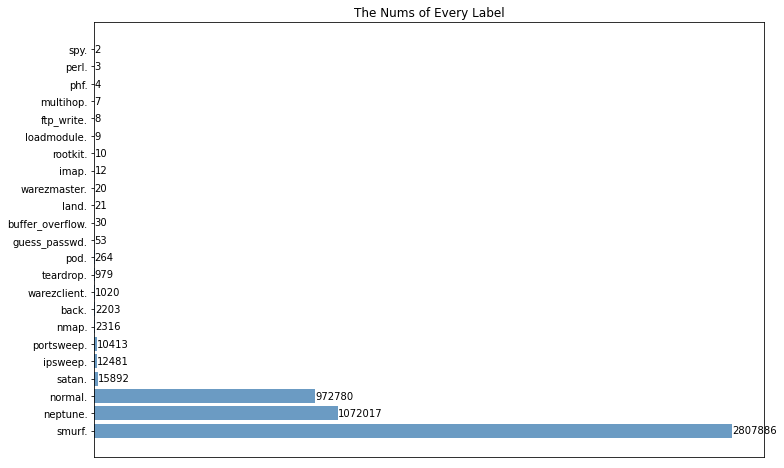

In [9]:
n = len(labels)
X = np.arange(n)
Y = labels_nums.values.tolist()

plt.figure(figsize=(12,8))
plt.barh(range(n), Y, align = 'center',color='steelblue', alpha = 0.8)

plt.title('The Nums of Every Label')
plt.yticks(range(n),labels_nums.index.tolist())
plt.xticks([])

for x,y in enumerate(Y):
    plt.text(y+100, x,'%s' %y, va='center')

plt.show()

由上图大概了解数据构成，发现大多数居于三类问题，其他类别较少，可能分不出来

## 2. 数据处理

### 2.1 将非数值型数据转换为可标识的数据

有三列是object对象，需要将其转换为数值型(这部分必须用全数据，才能包括所有类型)

- 1   protocol_type                object 
- 2   service                    object 
-  3   flag                      object 

In [10]:
def make_labels(datas):
    
    value = 0
    dicts = {}
    datas = list(set(datas))
    for label in datas:
        dicts[label] = value
        value += 1
    return dicts

In [11]:
protocol_type_dict = make_labels(datas['protocol_type'].values.tolist())
service_dict = make_labels(datas['service'].values.tolist())
flag_dict = make_labels(datas['flag'].values.tolist())
labels_dict = make_labels(labels)

In [12]:
datas['protocol_type'] = datas['protocol_type'].apply(lambda x: protocol_type_dict[x])
datas['service'] = datas['service'].apply(lambda x: service_dict[x])
datas['flag'] = datas['flag'].apply(lambda x: flag_dict[x])
datas['labels'] = datas['labels'].apply(lambda x: labels_dict[x])

datas

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,2,20,3,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,3
1,0,2,20,3,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,3
2,0,2,20,3,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,3
3,0,2,20,3,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,3
4,0,2,20,3,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898425,0,2,20,3,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,3
4898426,0,2,20,3,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,3
4898427,0,2,20,3,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,3
4898428,0,2,20,3,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,3


In [74]:
# 保存下来，免得再运行，文件是真的有点大
# datas.to_csv('./exp2/process_data.csv', index=False)

# 保存一下labels字典，便于之后不用再运行之前的数据
# with open('./data2/labels.json', 'w') as f:
#     json.dump(labels_dict, f)

### 2.2 由于数据量太大，随机采样10%做测试，再取用所有数据集

In [76]:
datas = pd.read_csv('./exp2/process_data.csv')

sample_df = np.random.permutation(len(datas))
temp_datas = datas.take(sample_df[:len(datas)//10])
temp_datas

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
2729450,0,1,31,3,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,16
2738097,0,1,31,3,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,16
4569995,0,0,64,10,0,0,0,0,0,0,...,14,0.05,0.09,0.0,0.0,0.0,0.0,1.0,1.0,0
4728313,0,0,64,10,0,0,0,0,0,0,...,1,0.00,0.06,0.0,0.0,0.0,0.0,1.0,1.0,0
134737,0,0,48,3,142,38299,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707496,0,0,64,4,0,0,0,0,0,0,...,24,0.09,0.06,0.0,0.0,1.0,1.0,0.0,0.0,0
1826530,0,1,31,3,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,16
2427988,0,1,31,3,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,16
648367,0,0,64,4,0,0,0,0,0,0,...,6,0.02,0.06,0.0,0.0,1.0,1.0,0.0,0.0,0


In [87]:
temp_datas['labels'].value_counts(), labels_dict

(16    281035
 0     107334
 13     96877
 5       1581
 7       1264
 20      1053
 12       236
 4        201
 2        122
 9         99
 10        24
 21         4
 15         3
 17         3
 22         3
 8          2
 19         2
 Name: labels, dtype: int64,
 {'rootkit.': 0,
  'perl.': 1,
  'warezclient.': 2,
  'normal.': 3,
  'nmap.': 4,
  'satan.': 5,
  'imap.': 6,
  'pod.': 7,
  'portsweep.': 8,
  'buffer_overflow.': 9,
  'guess_passwd.': 10,
  'warezmaster.': 11,
  'smurf.': 12,
  'phf.': 13,
  'back.': 14,
  'neptune.': 15,
  'ipsweep.': 16,
  'spy.': 17,
  'multihop.': 18,
  'loadmodule.': 19,
  'teardrop.': 20,
  'land.': 21,
  'ftp_write.': 22})

## 3. 决策树

### 3.1 划分训练集和测试集

In [78]:
X_train,X_test, y_train, y_test = train_test_split(temp_datas.iloc[:, :-1], temp_datas.iloc[:, -1], random_state=20, test_size=0.33)

### 3.2 决策树预测

In [79]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [80]:
y_predicts = clf.predict(X_test)
cm = confusion_matrix(y_test, y_predicts)

### 3.3 绘制混淆矩阵

这部分标签不太对，还需要改，现在看的头晕

In [81]:
def read_dict(file='./data2/labels.json'):
    with open(file, 'r') as f:
        return json.load(f)

labels_dict = read_dict()
labels_dict_keys = list(labels_dict.keys())
temp_label_lists = list(set(y_test))

In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds, plot_shape=(12,10)):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=plot_shape)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

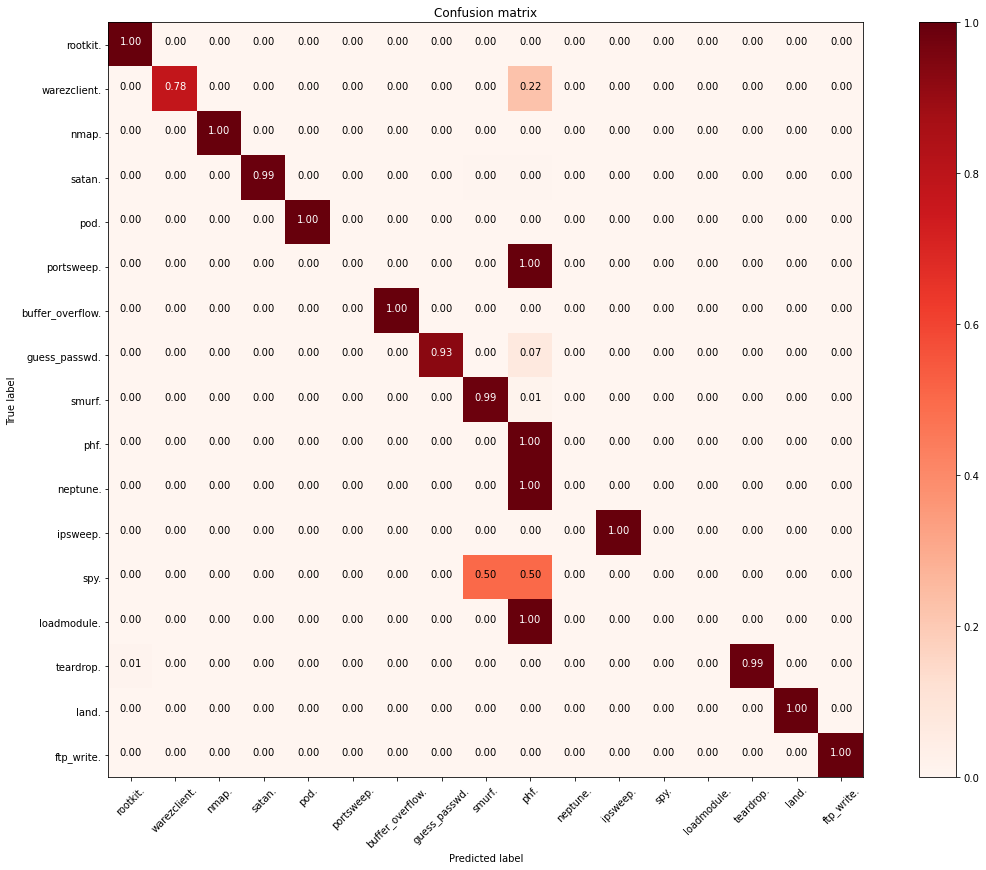

In [91]:
# sns.heatmap(df_cm, annot=True, cmap=plt.cm.Reds, normalize=True)

plot_confusion_matrix(cm, classes=[labels_dict_keys[i] for i in temp_label_lists], normalize=True, plot_shape=(16,12))

In [20]:
cm = ConfusionMatrix(actual_vector=y_test.tolist(), predict_vector=predicts.tolist())
print(cm)

Predict     0           2           4           5           7           9           10          11          12          13          16          20          21          
Actual
0           35330       0           0           0           0           1           0           0           0           1           0           0           0           

2           0           16          0           0           0           0           0           0           0           2           0           0           0           

4           0           0           69          0           0           0           0           0           0           1           0           0           0           

5           0           0           0           537         0           0           0           0           3           6           0           0           0           

7           0           0           0           0           407         0           0           0           1           3           0           

### 3.4 查看其结果

- 采用 [宏平均](https://blog.csdn.net/weixin_42864175/article/details/90521758)

In [54]:
print(f"The Precision is: {precision_score(y_test, y_predicts, average='macro'):.4f}")
print(f"The Recall is: {recall_score(y_test, y_predicts, average='macro'):.4f}")
print(f"The F1_score is: {f1_score(y_test, y_predicts, average='macro'):.4f}")

The Precision is: 0.6839
The Recall is: 0.7065
The F1_score is: 0.6942


### 3.5 绘制ROC曲线

- [python实现二分类和多分类的ROC曲线](https://zhuanlan.zhihu.com/p/266386193?utm_source=wechat_session)

找的代码有些问题，待实现……

In [89]:
# classifier = OneVsRestClassifier(DecisionTreeClassifier(random_state=0))
# y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
n_classes = len(temp_label_lists)
fpr = {}
tpr = {}
roc_auc = {}

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.values.tolist()[i], y_score[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [ ]:
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## 4. 优化模型

`之前存在的问题: `
1. 数据集随机划分为训练集和测试集，而真实的是用某个数据集训练，另一个数据集预测，测试集中可能存在未知的攻击。比如较少的几个数据
2. 没有归一化、标准化等处理
3. 之前直接将非数值型数据给一个数值，但是这样并没有很好的线性关系

In [2]:
datas = pd.read_csv('./data2/datas.csv')

In [3]:
datas

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898425,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898426,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


In [ ]:
def read_dict(file='./data2/labels.json'):
    with open(file, 'r') as f:
        return json.load(f)

labels_dict = read_dict()

datas['labels'] = datas['labels'].apply(lambda x: labels_dict[x])

打乱顺序取10%数据

In [21]:
sample_df = np.random.permutation(len(datas))
temp_datas = datas.take(sample_df[:len(datas)//10])
temp_datas

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
2925724,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,12
2467282,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,12
1733020,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,12
1350735,1,tcp,smtp,SF,735,333,0,0,0,0,...,147,0.71,0.03,0.01,0.01,0.0,0.0,0.0,0.0,3
608974,0,tcp,private,S0,0,0,0,0,0,0,...,10,0.04,0.07,0.00,0.00,1.0,1.0,0.0,0.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191176,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,12
24133,0,tcp,http,SF,224,5336,0,0,0,0,...,255,1.00,0.00,0.02,0.01,0.0,0.0,0.0,0.0,3
2052831,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,12
2005490,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,12


### 4.1 One-hot 处理

#### 4.1.1 one-hot

In [22]:
data_features, data_labels = temp_datas.iloc[:,:-1], temp_datas.iloc[:, -1]

In [23]:
data_labels.shape

(489843,)

In [24]:
protocol_types =  pd.get_dummies(data_features['protocol_type'], prefix='protocol_type')
services =  pd.get_dummies(data_features['service'], prefix='service')
flags =  pd.get_dummies(data_features['flag'], prefix='flag')

data_features = pd.concat([data_features, protocol_types, services, flags], axis=1)

In [25]:
data_features = data_features.drop(columns=['protocol_type', 'service', 'flag'], axis=1)
data_features

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
2925724,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2467282,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1733020,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1350735,1,735,333,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
608974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191176,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24133,0,224,5336,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2052831,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2005490,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### 4.1.2 划分预测

In [26]:
X_train,X_test, y_train, y_test = train_test_split(data_features, data_labels, random_state=20, test_size=0.2)

In [27]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_predicts = clf.predict(X_test)
cm = confusion_matrix(y_test, y_predicts)

#### 4.1.3 查看结果

In [30]:
print(f"The Precision is: {precision_score(y_test, y_predicts, average='macro'):.4f}")
print(f"The Recall is: {recall_score(y_test, y_predicts, average='macro'):.4f}")
print(f"The F1_score is: {f1_score(y_test, y_predicts, average='macro'):.4f}")

The Precision is: 0.9990
The Recall is: 0.9808
The F1_score is: 0.9893


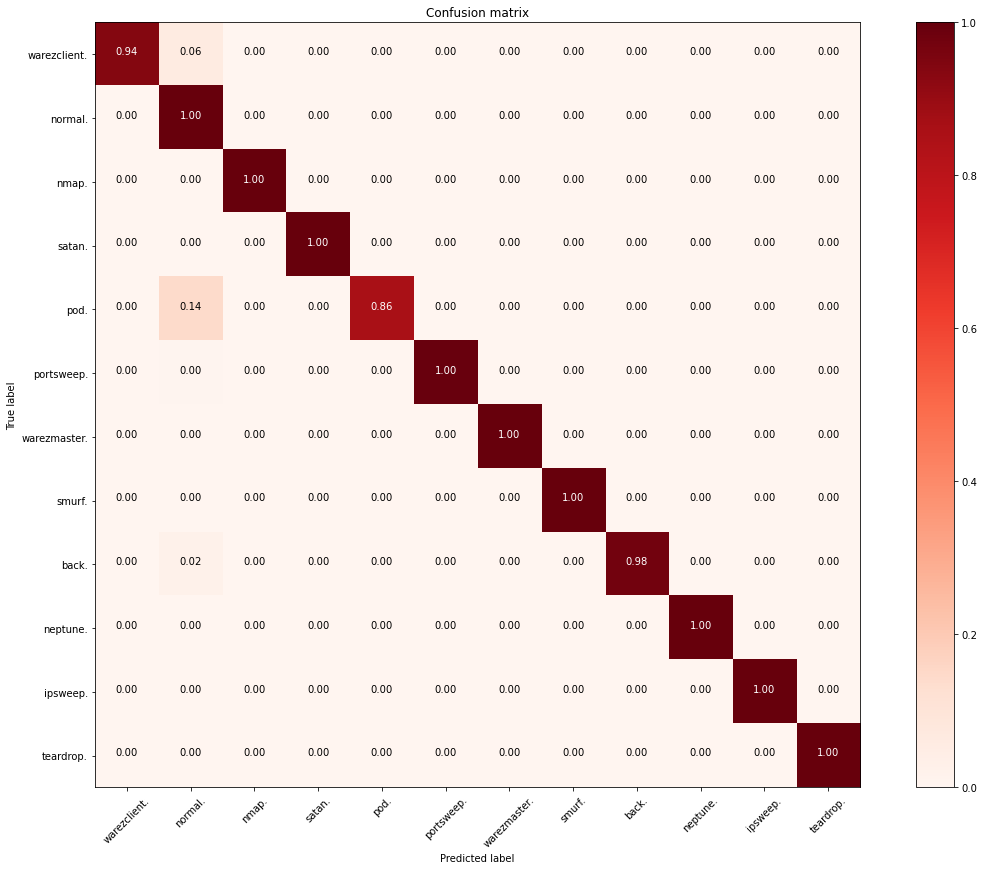

In [32]:
labels_dict_keys = list(labels_dict.keys())
temp_label_lists = list(set(y_test))

plot_confusion_matrix(cm, classes=[labels_dict_keys[i] for i in temp_label_lists], normalize=True, plot_shape=(16,12))